In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit

datadir = f"./data/comparison_imagenet"
plotdir = f"./plots/comparison_imagenet"

if not os.path.exists(plotdir):
    os.makedirs(plotdir)


In [3]:
### >>>> TINYIMAGENET

############################### EWC

ewc_perf_tiny_path = f'{datadir}/tinyim_ewc/performance.csv'
ewc_traj_tiny_path = f'{datadir}/tinyim_ewc/filtered_trajectories_tinyim_ewc_task_0_avg_pool2d.pkl'

ewc_perf_tiny_df = pd.read_csv(ewc_perf_tiny_path)
ewc_trajectories_filter_tiny = pd.read_pickle(ewc_traj_tiny_path)

############################### REPLAY

replay_perf_tiny_path = f'{datadir}/tinyim_replay/performance.csv'
replay_traj_tiny_path = f'{datadir}/tinyim_replay/filtered_trajectories_tinyim_replay_task_0_avg_pool2d.pkl'

replay_perf_tiny_df = pd.read_csv(replay_perf_tiny_path)
replay_trajectories_filter_tiny = pd.read_pickle(replay_traj_tiny_path)

In [4]:
def prepare_performance(perf_df, algo_join_cols,last_task=10):
    # get stability plasticity and capacity
    stability_df = perf_df[(perf_df['phase'] == last_task) & (perf_df['task'] == 0)]
    plasticity_df = perf_df[(perf_df['phase'] == last_task) & (perf_df['task'] == last_task)]

    # drop columns manager, ridge result, run, index
    stability_df = stability_df.drop(columns=['manager', 'ridge_result', 'run', 'index'])
    plasticity_df = plasticity_df.drop(columns=['manager', 'ridge_result', 'run', 'index'])

    # rename cl_performance to plasticity and stability
    stability_df.rename(columns={'cl_result': 'stability'}, inplace=True)
    plasticity_df.rename(columns={'cl_result': 'plasticity'}, inplace=True)

    plasticity_df = plasticity_df.drop(columns=['task', 'phase'])
    stability_df = stability_df.drop(columns=['task', 'phase'])

    # merge both dataframes
    stability_plasticity_df = pd.merge(stability_df, plasticity_df, on=['tstamp', 'algorithm', 'dense_size'].extend(algo_join_cols))
    stability_plasticity_df['capacity'] = stability_plasticity_df['stability'] + stability_plasticity_df['plasticity']
    return stability_plasticity_df

def prepare_trajectories(filter_traj_df, last_task=10):
    run_names = filter_traj_df['run']
    run_names = run_names.str.split('_', expand=True)
    run_names['tstamp'] = run_names[0]
    filter_traj_df = filter_traj_df.drop(columns=['run'])
    filter_traj_df['tstamp'] = run_names['tstamp']
    filter_traj_df = filter_traj_df.reset_index()
    filter_traj_df_last = filter_traj_df[filter_traj_df['phase'] == last_task]
    distances_to_first = filter_traj_df_last[['tstamp', 'distance_to_first_null_space', 'distance_to_first_in_plane']]
    filter_traj_df = filter_traj_df.drop(columns=['distance_to_first_null_space', 'distance_to_first_in_plane', 'phase', 'index'])

    # group by tstamp
    filter_traj_df_grp = filter_traj_df.groupby(['tstamp'])
    distances_cumulative = filter_traj_df_grp.sum(numeric_only=True).reset_index()

    # join on tstamp
    distance_df = pd.merge(distances_cumulative, distances_to_first, on=['tstamp'])
    return distance_df

def join_frames(distance_df, perf_df):
    # tstamps are floats
    distance_df['tstamp'] = distance_df['tstamp'].astype(float)
    perf_df['tstamp'] = perf_df['tstamp'].astype(float)

    # sort both frames by ascending tstamp
    distance_df = distance_df.sort_values(by=['tstamp'])
    perf_df = perf_df.sort_values(by=['tstamp'])

    # rename tstamps to tstamp_d and tstamp_s
    distance_df.rename(columns={'tstamp': 'tstamp_d'}, inplace=True)
    perf_df.rename(columns={'tstamp': 'tstamp_s'}, inplace=True)

    # reset indicees and drop index
    distance_df = distance_df.reset_index()
    distance_df = distance_df.drop(columns=['index'])

    perf_df = perf_df.reset_index()
    perf_df = perf_df.drop(columns=['index'])

    # concatenate both dataframes along the columns
    combined_df = pd.concat([distance_df, perf_df], axis=1)
    return combined_df

In [5]:
# tiny imagenet
distance_df_ewc_tiny = prepare_trajectories(ewc_trajectories_filter_tiny, last_task=4)
perf_df_ewc_tiny = prepare_performance(ewc_perf_tiny_df, ['ewc_lambda'], last_task=4)
combined_df_ewc_tiny = join_frames(distance_df_ewc_tiny, perf_df_ewc_tiny)

distance_df_replay_tiny = prepare_trajectories(replay_trajectories_filter_tiny, last_task=4)
perf_df_replay_tiny = prepare_performance(replay_perf_tiny_df, ['replay_mem_size'], last_task=4)
combined_df_replay_tiny = join_frames(distance_df_replay_tiny, perf_df_replay_tiny)

/var/folders/7n/wpwh80rn01z3xkb5bl7v9wyh0000gn/T/ipykernel_46259/902340060.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = combined_df_ewc_tiny.groupby(['ewc_lambda']).mean().reset_index()
/Users/daniel/miniconda3/envs/pt/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


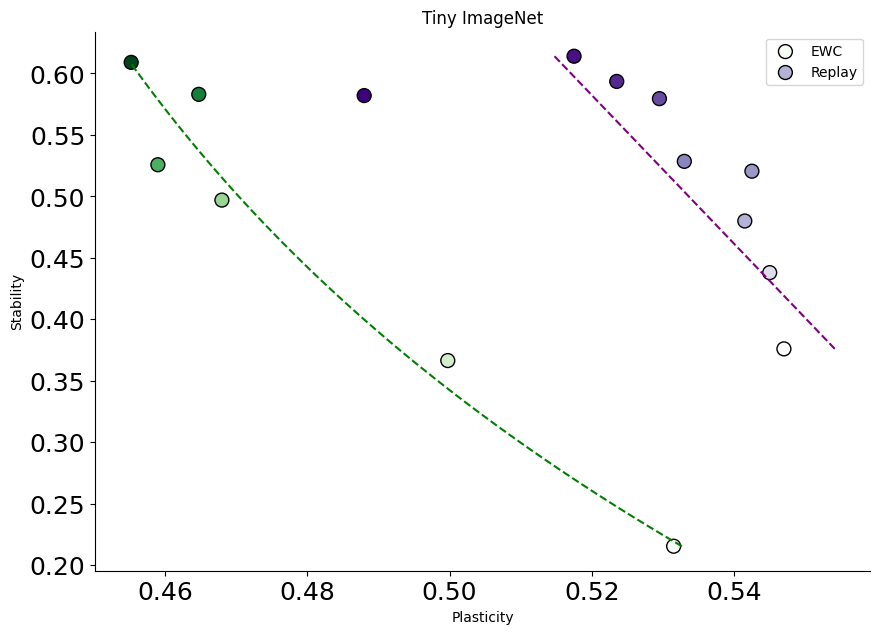

In [10]:
MARKER_SIZE = 100

def func(x, a, b, c, d):
    # 3rd order polynomial
    return a + b * np.exp(c * x)


######## EWC

# avg ewc conditions by ewc_lambda
df = combined_df_ewc_tiny.groupby(['ewc_lambda']).mean().reset_index()
plt.figure(figsize=(10,7))
plt.scatter(
    x=df['plasticity'],
    y=df['stability'],
    s=MARKER_SIZE,
    edgecolors='k',
    linewidths=1,
    label='EWC',
    cmap='Greens',
    c=df['ewc_lambda'],
    norm=LogNorm()
    )

# fit
x = np.linspace(df['stability'].min(), df['stability'].max(), 100)
popt, pcov = curve_fit(func, df['stability'], df['plasticity'], p0=(.5, 0, 0, 0))
plt.plot(func(x, *popt), x, 'g--')

plt.scatter(
    x=combined_df_replay_tiny['plasticity'],
    y=combined_df_replay_tiny['stability'],
    s=MARKER_SIZE,
    edgecolors='k',
    linewidths=1,
    label='Replay',
    cmap='Purples',
    c=combined_df_replay_tiny['replay_mem_size'],
    norm=LogNorm()
    )


######## REPLAY

# fit
x = np.linspace(combined_df_replay_tiny['stability'].min(), combined_df_replay_tiny['stability'].max(), 100)
popt, pcov = curve_fit(func, combined_df_replay_tiny['stability'], combined_df_replay_tiny['plasticity'], p0=(1, 0, -10, 0), maxfev=10000)
plt.plot(func(x, *popt), x,  'purple', linestyle='--')

plt.legend()
plt.xlabel('Plasticity')
plt.ylabel('Stability')
plt.title('Tiny ImageNet')
sns.despine()
# increase size of tick font
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# save
plt.savefig(f'{plotdir}/tiny_imagenet_ewc_replay_stability_plasticity.png')

/var/folders/7n/wpwh80rn01z3xkb5bl7v9wyh0000gn/T/ipykernel_46259/3898398755.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = combined_df_ewc_tiny.groupby(['ewc_lambda']).mean().reset_index()


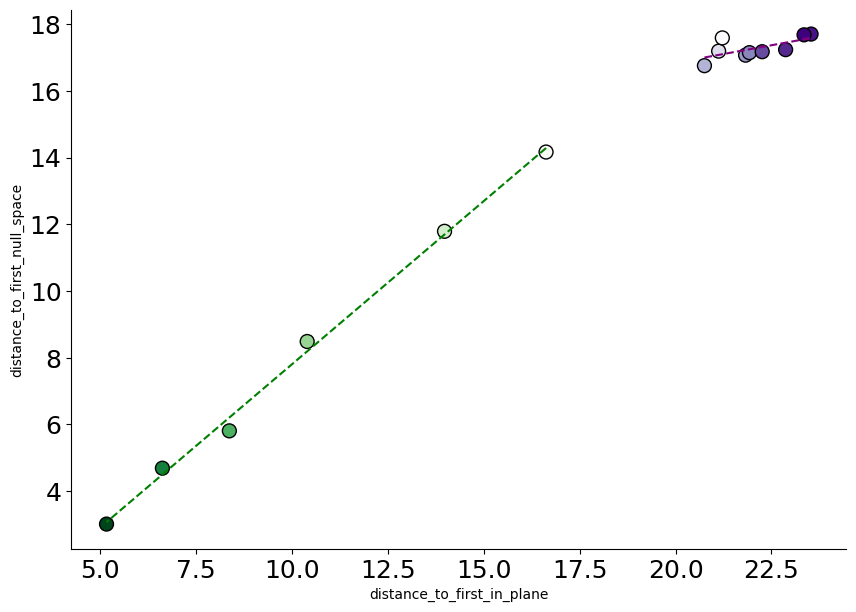

In [11]:
# also show nullspace vs range movement

plt.figure(figsize=(10,7))

X = 'distance_to_first_in_plane'
Y = 'distance_to_first_null_space'

######## EWC
df = combined_df_ewc_tiny.groupby(['ewc_lambda']).mean().reset_index()
slope, intercept, r_value, p_value, std_err = linregress(df[X], df[Y])
x = df[X]
plt.plot(x, slope * x + intercept, '--', c='green')

plt.scatter(
    x=df[X],
    y=df[Y],
    s=MARKER_SIZE,
    edgecolors='k',
    linewidths=1,
    label='EWC',
    cmap='Greens',
    c=df['ewc_lambda'],
    norm=LogNorm()
)

######## REPLAY

x = combined_df_replay_tiny[X]
slope, intercept, r_value, p_value, std_err = linregress(combined_df_replay_tiny[X], combined_df_replay_tiny[Y])
plt.plot(x, slope * x + intercept, '--', c='purple')

plt.scatter(
    x=combined_df_replay_tiny[X],
    y=combined_df_replay_tiny[Y],
    s=MARKER_SIZE,
    edgecolors='k',
    linewidths=1,
    label='Replay',
    cmap='Purples',
    c=combined_df_replay_tiny['replay_mem_size'],
    norm=LogNorm()
)

# axis labels
plt.xlabel(X)
plt.ylabel(Y)
sns.despine()

# increase size of tick font
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# save
plt.savefig(f'{plotdir}/tiny_imagenet_ewc_replay_nullspace_range.png')

